In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from common.processor.utils import Utils
from common.extractor.alpaca_extractor import AlpacaExtractor
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio import Portfolio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## Import standard packages
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
orivault = ADatabase("ori")
alp = AlpacaExtractor(paper=False)

In [5]:
orivault.connect()
portfolio_dictionary = orivault.retrieve("results").to_dict("records")[0]
orivault.disconnect()

In [6]:
pm = Portfolio.from_dict(portfolio_dictionary)
print(portfolio_dictionary)

{'ranking_metric': 'volume_return', 'timeframe': 'DAY', 'position_type': 'long', 'grouping_type': 'STANDARD_DEV', 'selection_type': 'top_blacklist', 'allocation_type': 'equal', 'risk_type': 'coefficient_of_variation', 'selection_percentage': 1, 'stoploss': 0.05, 'num_of_groups': 1, 'max_price': 10, 'min_price': 1, 'max_market_cap': 5000000, 'min_market_cap': 1000000, 'rolling_window': 10, 'leverage': 1, 'date': Timestamp('2021-12-30 00:00:00'), 'pnl': 0.24121285212344917, 'raw_pnl': 57.61726195208843, 'downside': 0.95, 'coefficient_of_variation': 1.5036456503188658, 'portfolio_std': 0.16041868113827026, 'sharpe_ratio': -7.58949162469379, 'tracking_error': 0.40154047060549136, 'information_ratio': -3.0320635803096945}


In [7]:
## Retrieve existing stocks 
index = alp.assets().sort_values("ticker")
tickers = index["ticker"].values
tickers_per_batch = int(1000)
batchs = [tickers[i:i + tickers_per_batch] for i in range(0, len(tickers), tickers_per_batch)]
bars = []
[bars.append(alp.latest_bars_bulk(batch)) for batch in batchs]
todays_bar = pd.concat(bars)
index = index.merge(todays_bar,on="ticker",how="left")

'SVA'


In [8]:
end = Utils.last_weekday(alp.clock())
start = (end - timedelta(days=pm.rolling_window*3))
print(start,end)

2025-04-29 16:00:00-04:00 2025-05-29 16:00:00-04:00


In [9]:
tickers_per_batch = int(10000/(pm.rolling_window*4)/5)
print(tickers_per_batch)

50


In [10]:
relevant_tickers = index["ticker"]
batchs = [relevant_tickers[i:i + tickers_per_batch] for i in range(0, len(relevant_tickers), tickers_per_batch)]

In [11]:
prices = []
for batch in tqdm(batchs):
    try:
        tickers_data = alp.prices_bulk(batch,start,end)
        for ticker in batch:
            try:
                price = tickers_data[tickers_data["ticker"] == ticker].copy()
                price = p.lower_column(price)
                price = p.utc_date(price)
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                price["market_cap"] = price["adjclose"] * price["volume"]
                price["coefficient_of_variation"] = 1
                price["dividend"] = 0
                if price.index.size > pm.rolling_window*2:
                    for member in Metric:
                        price = member.calculate(price,timeframe=pm.rolling_window,live=True)
                    for member in Indicator:
                        price = member.calculate(price,timeframe=pm.rolling_window,live=True)
                prices.append(price)
            except Exception as e:
                print(str(e))
    except Exception as e:
        print(str(e))

 10%|████████████████████▌                                                                                                                                                                                              | 22/226 [01:06<10:18,  3.03s/it]

'BHK.RT'


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 114/226 [05:35<05:18,  2.84s/it]

'KKRT'


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 162/226 [07:50<03:00,  2.81s/it]

'PTNM'


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 169/226 [08:11<02:46,  2.93s/it]

'REMG'


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 170/226 [08:14<02:40,  2.87s/it]

'RGLO'


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 174/226 [08:25<02:24,  2.78s/it]

'RSSX'


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 192/226 [09:16<01:34,  2.79s/it]

'SVA'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [10:51<00:00,  2.88s/it]


In [12]:
simulation = pd.concat(prices)
simulation.sort_values("date", inplace=True)
trades = pm.recs(simulation.copy())
trades.to_dict("records")

[{'year': 2025,
  'day': 149,
  'ticker': 'AFIF',
  'date': Timestamp('2025-05-29 00:00:00+0000', tz='UTC'),
  'adjclose': 9.24,
  'high': 9.25,
  'low': 9.235,
  'volume': 305422,
  'month': 5,
  'quarter': 2,
  'week': 22,
  'weekday': 3,
  'market_cap': 2822099.2800000003,
  'risk': 1,
  'dividend': 0.0,
  'adjclose_test': 9.2301,
  'high_test': 9.24,
  'low_test': 9.22,
  'volume_test': 8708.0,
  'average_return': 0.0016378735120455624,
  'standard_dev': 0.020529352969186423,
  'rolling_dollar_volume': 491189.72228,
  'simple_moving_average': 9.22911,
  'drawdown': 0.0032467532467531776,
  'distance': 1.8308424935992105,
  'cooked_return': 99.68946618776069,
  'next_close': nan,
  'next_high': nan,
  'next_low': nan,
  'price_to_return': 563481.2415076938,
  'optimal': nan,
  'adr': 0.002790525452904434,
  'sma': -0.0011785714285713622,
  'sma_corr': 0.0011752818372673254,
  'ema': -0.0015745089271317347,
  'ema_corr': 34.03614631865608,
  'bollinger_upper': 1.0032650114651918,
  '

In [13]:
ori = ADatabase("ori")
ori.connect()
ams = ori.retrieve("ams")
ori.disconnect()
dropped_columns = ["year","quarter","month","week","day","weekday","coefficient_of_variation","dividend","optimal"]
dropped_columns.extend([x for x in simulation.columns if "test" in x])
todays_view = simulation[simulation["date"]==simulation["date"].max()].drop(dropped_columns,axis=1).copy()
todays_view = todays_view.merge(ams[["ticker","NAME_OF_ISSUER","SHARE_VALUE","share_price"]],on="ticker",how="inner")
todays_view["pb"] = todays_view["adjclose"] / todays_view["share_price"] - 1
todays_view["weight"] = todays_view["SHARE_VALUE"]/todays_view["SHARE_VALUE"].sum()
todays_view["return"] = todays_view["pb"] * todays_view["weight"]

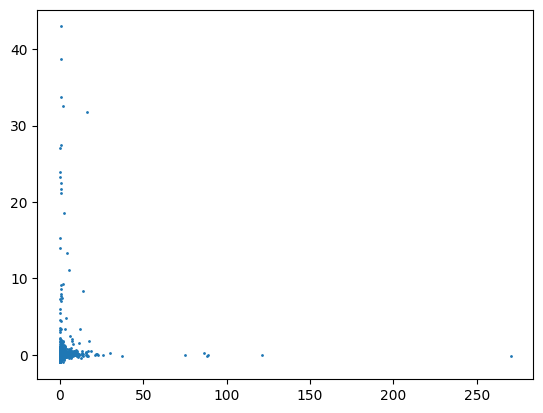

In [14]:
plt.scatter(todays_view["standard_dev"],todays_view["pb"],s=1)
plt.show()

In [15]:
winsored = todays_view.sort_values("pb",ascending=True).iloc[200:-200].round(4)
winsored.sort_values("return",ascending=False).head(20)

,date,adjclose,high,low,volume,ticker,market_cap,average_return,standard_dev,rolling_dollar_volume,...,vwap,market_impact,atr,volume_return,NAME_OF_ISSUER,SHARE_VALUE,share_price,pb,weight,return
2624,2025-05-29 00:00:00+00:00,139.19,143.4900,137.9100,370615167,NVDA,5.158593e+10,0.0433,2.2489,3.144916e+10,...,134.8472,9.750255e+06,3.5390,0.0,NVIDIA CORPORATION,3.395358e+10,108.38,0.2843,0.0531,0.0151
2025,2025-05-29 00:00:00+00:00,458.68,461.7200,455.3105,13982211,MSFT,6.413361e+09,0.0130,3.3664,8.605260e+09,...,455.8131,1.782391e+05,5.8125,0.0,MICROSOFT CORP,4.325658e+10,375.39,0.2219,0.0676,0.0150
1977,2025-05-29 00:00:00+00:00,358.43,367.7100,356.0000,88545666,TSLA,3.173742e+10,0.0578,9.3619,3.468615e+10,...,347.3536,3.113445e+06,12.1974,0.0,TESLA INC,9.140488e+09,259.16,0.3830,0.0143,0.0055
2134,2025-05-29 00:00:00+00:00,1184.86,1209.0000,1176.2800,3303079,NFLX,3.913686e+09,0.0259,10.3701,3.485390e+09,...,1191.4660,5.570863e+04,20.0737,0.0,NETFLIX INC,5.905597e+09,932.53,0.2706,0.0092,0.0025
433,2025-05-29 00:00:00+00:00,264.37,265.4099,262.5300,5081992,JPM,1.343526e+09,0.0079,2.6044,2.049259e+09,...,264.4106,8.396034e+04,4.3614,0.0,JPMORGAN CHASE & CO.,1.115283e+10,245.30,0.0777,0.0174,0.0014
2144,2025-05-29 00:00:00+00:00,1015.23,1024.5825,1004.7000,1266245,NOW,1.285530e+09,0.0056,10.5168,1.242912e+09,...,1021.9566,2.183814e+04,17.6069,0.0,SERVICENOW INC,2.587056e+09,796.14,0.2752,0.0040,0.0011
60,2025-05-29 00:00:00+00:00,97.10,97.7700,96.8509,14343738,WMT,1.392777e+09,0.0009,0.8190,1.936085e+09,...,97.1485,3.038147e+05,2.0578,0.0,WALMART INC,6.232520e+09,87.79,0.1060,0.0097,0.0010
170,2025-05-29 00:00:00+00:00,244.16,244.9441,241.4923,5245302,GE,1.280693e+09,0.0447,5.4799,1.386232e+09,...,236.3262,1.090339e+05,4.8974,0.0,GE AEROSPACE,3.019177e+09,200.15,0.2199,0.0047,0.0010
2693,2025-05-29 00:00:00+00:00,162.90,165.3200,161.4900,6995831,ORCL,1.139621e+09,0.0127,2.5610,1.259540e+09,...,159.9718,1.417851e+05,3.2400,0.0,ORACLE CORP,3.214140e+09,139.81,0.1652,0.0050,0.0008
2403,2025-05-29 00:00:00+00:00,177.87,178.1800,174.9300,5727518,PM,1.018754e+09,0.0328,3.4967,8.497777e+08,...,175.3158,8.715062e+04,2.6563,0.0,PHILIP MORRIS INTL INC,3.720146e+09,158.73,0.1206,0.0058,0.0007


In [16]:
winsored["return"].sum()

np.float64(0.0384)